# Import 

In [1]:
from utils.utils import seed_torch, get_best_model_path
from dataclasses import dataclass
from pytorch_forecasting import TemporalFusionTransformer
from exp.tft import Experiment_TFT
from explainers import *
from exp.config import Split, FeatureFiles
from utils.interpreter import *
from utils.plotter import PlotResults

import numpy as np
import gc, os
import pandas as pd

# Arguments

In [7]:
from run_tft import get_argparser

In [17]:
argv = """
--result_path scratch/no_scale
--data_path Top_20.csv
--test
""".split()
args = get_argparser().parse_args(argv)

args.explainer = 'FO'
seed_torch(args.seed)

Global seed set to 7


# Input

In [18]:
experiment = Experiment_TFT(args)

total_data = experiment.age_dataloader.read_df()
print(total_data.shape)
print(total_data.head(3))

train_data, val_data, test_data = experiment.age_dataloader.split_data(
    total_data, Split.primary()
)

(20720, 13)
        Date  FIPS  UNDER5  AGE517  AGE1829  AGE3039  AGE4049  AGE5064  \
0 2020-12-13  2261  0.0062   0.016    0.014   0.0146   0.0117   0.0235   
1 2020-12-14  2261  0.0062   0.016    0.014   0.0146   0.0117   0.0235   
2 2020-12-15  2261  0.0062   0.016    0.014   0.0146   0.0117   0.0235   

   AGE6574  AGE75PLUS  VaccinationFull  Cases  SinWeekly  
0   0.0103     0.0004              0.0    2.0    -0.7818  
1   0.0103     0.0004              0.0    1.0     0.0000  
2   0.0103     0.0004              0.0    1.0     0.7818  

Train samples 12740, validation samples 560, test samples 560
637 days of training, 14 days of validation data, 14 days of test data.

Fitting scalers on train data


## Config

In [36]:
age_data = experiment.age_dataloader
time_index = age_data.time_index
features = age_data.static_reals

# Interpret

## Load Model

In [20]:
model_path = get_best_model_path(args.result_path)
model = TemporalFusionTransformer.load_from_checkpoint(model_path)


Found best checkpoint model best-epoch=5.ckpt.


## Select Data

In [21]:
data = train_data.copy()

## Calculate Importance

In [22]:
dataset, dataloader = experiment.age_dataloader.create_timeseries(data)
# (x, (y, _)) = next(iter(dataloader))

In [102]:
# tuple of prediction, x, index
predictions, x, test_index = model.predict(
    dataloader, return_index=True, return_x=True
)
# since this is single target
predictions, trues = predictions[0], x['decoder_target'][0]

In [105]:
trues_numpy = np.float64(trues.numpy())

dtype('float32')

In [81]:
predictions = predictions.detach().cpu().numpy()
trues = trues.detach().cpu().numpy()

In [82]:
predictions_upscaled = age_data.upscale_target(predictions)
trues_upscaled = age_data.upscale_target(trues)

In [86]:
predictions

array([[-0.5174602 , -0.48869577, -0.4597846 , ..., -0.43869594,
        -0.48208186, -0.48430225],
       [-0.49500653, -0.4602807 , -0.44890168, ..., -0.48420146,
        -0.48578826, -0.4832596 ],
       [-0.46145996, -0.4464108 , -0.4648368 , ..., -0.48466858,
        -0.48244557, -0.4361967 ],
       ...,
       [-0.12029567, -0.47700384, -0.5361868 , ..., -0.13433173,
        -0.14126739, -0.14640132],
       [-0.44303522, -0.51592684,  0.14833173, ..., -0.1320912 ,
        -0.13371685, -0.13393745],
       [-0.43093857,  0.03964522, -0.13726178, ..., -0.14728943,
        -0.14735565, -0.38925532]], dtype=float32)

In [99]:
trues

(12200, 14)

In [107]:
trues_numpy[0]

array([-0.53725553, -0.53725553, -0.53725553, -0.53725553, -0.53725553,
       -0.53725553, -0.53725553, -0.53725553, -0.53725553, -0.53725553,
       -0.53725553, -0.53725553, -0.53725553, -0.53725553])

In [92]:
trues_upscaled = age_data.upscale_target(trues)

In [113]:
trues_upscaled[trues_upscaled<0] = 0
trues_upscaled

array([[  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       ...,
       [696.     ,   0.     ,   0.     , ..., 128.99997, 155.     ,
          0.     ],
       [  0.     ,   0.     , 858.     , ..., 155.     ,   0.     ,
          0.     ],
       [  0.     , 858.     , 159.     , ...,   0.     ,   0.     ,
          0.     ]], dtype=float32)

In [83]:
predictions_upscaled

array([[ 23.765467,  58.298973,  93.00869 , ..., 118.32693 ,  66.2394  ,
         63.573692],
       [ 50.722557,  92.41311 , 106.0743  , ...,  63.694725,  61.789635,
         64.82546 ],
       [ 90.99728 , 109.06472 ,  86.9432  , ...,  63.133873,  65.80276 ,
        121.327415],
       ...,
       [500.5863  ,  72.3359  ,   1.283044, ..., 483.73514 , 475.40845 ,
        469.24484 ],
       [113.11733 ,  25.60641 , 823.0903  , ..., 486.42505 , 484.47333 ,
        484.2085  ],
       [127.6401  , 692.60535 , 480.21744 , ..., 468.17862 , 468.09912 ,
        177.68347 ]], dtype=float32)

In [78]:
trues

[tensor([[-0.5373, -0.5373, -0.5373,  ..., -0.5373, -0.5373, -0.5373],
         [-0.5373, -0.5373, -0.5373,  ..., -0.5373, -0.5373, -0.5373],
         [-0.5373, -0.5373, -0.5373,  ..., -0.5373, -0.5373, -0.5373],
         ...,
         [ 0.0425, -0.5373, -0.5373,  ..., -0.4298, -0.4081, -0.5373],
         [-0.5373, -0.5373,  0.1774,  ..., -0.4081, -0.5373, -0.5373],
         [-0.5373,  0.1774, -0.4048,  ..., -0.5373, -0.5373, -0.5373]])]

In [71]:
pred[0][0].shape, pred[1]['decoder_target'][0].shape

torch.Size([12200, 14])

In [48]:
explainer = explainer_factory(args, model, dataloader, features)

# train any baseline or parameters
explainer.train_generators(train_data)
all_scores = explainer.attribute(train_data, args.disable_progress)

Initialized explainer: Feature Occlusion.



100%|██████████| 610/610 [04:42<00:00,  2.16it/s]


In [41]:
bounds = []
dists = []
for feature in features:
    bounds.append([data[feature].mean(), data[feature].std()])
    dists.append('norm')
bounds

[[0.059515, 0.01340609495773683],
 [0.158275, 0.03657870826993368],
 [0.159235, 0.03502078729977389],
 [0.14223000000000002, 0.03143647039307667],
 [0.12296000000000001, 0.026028726026034135],
 [0.174185, 0.03663495082443947],
 [0.08066999999999999, 0.018189174502412295],
 [0.057725000000000005, 0.016755891879269045]]

In [42]:
sp = SALib.ProblemSpec({
    "num_vars": len(features),
    'names': features,
    'bounds': bounds,
    'dists': dists,
    'sample_scaled': False
})

In [13]:
seq_len = dataloader.seq_len
pred_len = dataloader.pred_len

time_range = range(
    data[time_index].min() + seq_len - 1, 
    data[time_index].max() - pred_len + 1
)

In [14]:
data = data.sort_values(
    by=[time_index]+dataloader.group_ids
).reset_index(drop=True)

N = data[data[time_index]<=time_range[-1]].shape[0]
num_group_ids = data[dataloader.group_ids].nunique().max()

In [167]:
num_morris_samples = len(features)+1
y_hats = np.ndarray(
    shape=(num_morris_samples, num_group_ids, pred_len)
)
all_scores = np.full(
    (
        data[data[time_index]<=time_range[-1]].shape[0], 
        len(features), pred_len
    ), fill_value=np.nan, dtype=np.float32
)

for t in tqdm(time_range, disable=args.disable_progress):
    x = data[
        (data[time_index]  > t - seq_len) & 
        (data[time_index] <= (t + pred_len))
    ]
    
    selected_index = x[x[time_index] <= t].index
    x_hat = x.copy()
    
    samples = SALib.sample.morris.sample(sp, num_group_ids)
    samples_reshaped = samples.reshape((-1, num_group_ids, len(features)))
    
    for sample_index in range(num_morris_samples):
        group_samples = samples_reshaped[sample_index]
        group_samples = np.tile(group_samples, [seq_len, 1])
        
        x_hat.loc[selected_index, features] = group_samples
        _, data_loader = dataloader.create_timeseries(x_hat)
        
        y_hat_t = model.predict(data_loader)[0]
        y_hats[sample_index] = y_hat_t

    y_hats_reshaped = y_hats.reshape((-1, pred_len))
    for index, Y in enumerate(y_hats_reshaped.T):
        morris_index = SALib.analyze.morris.analyze(
            sp, samples, Y
        )['mu_star'].data
        
        all_scores[x[x[time_index] == t].index, :, index] = morris_index
        
all_scores = all_scores[num_group_ids*(seq_len-1):]

In [49]:
time_range = explainer.time_range(data)
df = data[
    (data[time_index]>=time_range[0]) & 
    (data[time_index]<=time_range[-1])
][['Date', 'FIPS']]

global_rank = calculate_global_rank(
    df, all_scores, features
)

     Feature      Score
0     UNDER5   7.820252
1     AGE517  11.245102
2    AGE1829  12.262063
3    AGE3039  12.383718
4    AGE4049  13.354955
5    AGE5064  10.479348
6    AGE6574  21.620716
7  AGE75PLUS  10.833842


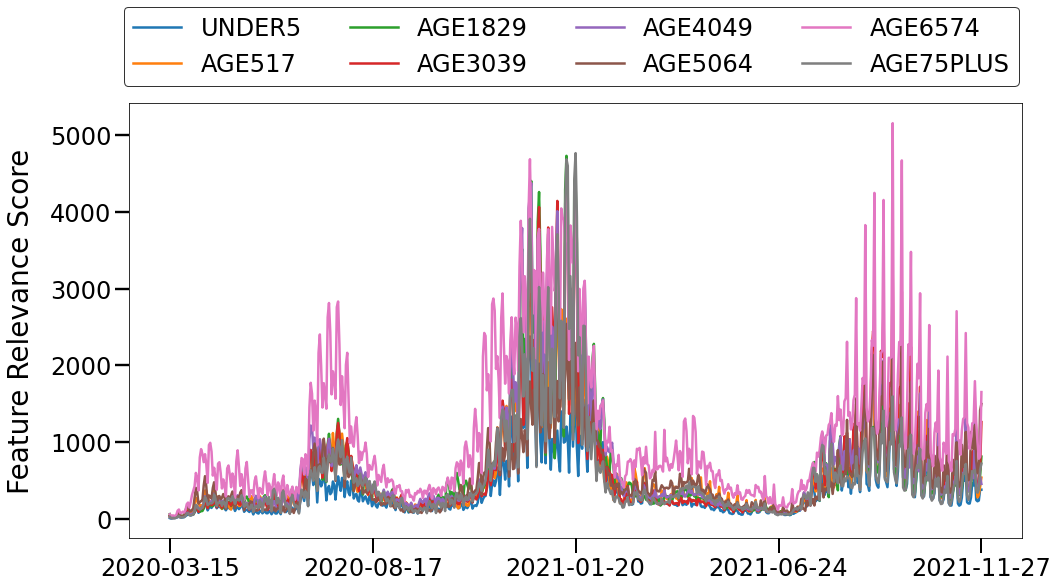

In [50]:
group_agg_scores_df = align_interpretation(df, all_scores, features)

# plot local interpretations
plotter = PlotResults(
    figPath=args.result_folder, targets=dataloader.targets, 
    show=not args.disable_progress
)
plotter.local_interpretation(
    group_agg_scores_df, dataloader.static_reals
)

# Evaluate

The white box evaluation is only available for age group features.

## Load ground truth

In [44]:
# Load ground truth
group_cases = pd.read_csv(
    os.path.join(FeatureFiles.root_folder, 'Cases by age groups.csv')
)
group_cases['end_of_week'] = pd.to_datetime(group_cases['end_of_week'])


## Calculate rank score

In [52]:
group_agg_scores_df

,Date,UNDER5,AGE517,AGE1829,AGE3039,AGE4049,AGE5064,AGE6574,AGE75PLUS
0,2020-03-15,14.683243,29.013805,66.520065,46.288101,31.330685,45.026295,64.299576,33.460934
1,2020-03-16,9.159084,18.195194,25.428175,20.495867,17.493103,23.094101,26.398293,13.389536
2,2020-03-17,12.788517,18.948488,31.918274,26.244307,23.323050,15.491437,49.577663,16.266750
3,2020-03-18,15.293900,18.618393,36.171654,27.029615,24.804817,14.829394,47.999275,17.187077
4,2020-03-19,15.408850,21.351851,31.474110,23.867508,21.613068,17.340008,36.207344,15.070912
...,...,...,...,...,...,...,...,...,...
618,2021-11-23,249.961990,462.734802,468.796326,465.141052,435.649597,760.410522,1265.038086,423.037750
619,2021-11-24,233.493225,282.872650,371.965820,386.729797,396.875397,597.965515,1011.512878,344.716095
620,2021-11-25,243.440536,313.716156,409.070099,512.589050,441.966278,653.472168,786.565247,388.279388
621,2021-11-26,382.585449,420.306519,569.577820,661.027222,547.918945,1417.062256,811.142090,645.638245


In [92]:
# find a common start point
first_common_date = find_first_common_date(
    group_cases, group_agg_scores_df['Date'].values
)

# since age group ground truth is weekly aggregated
# do the same for predicted importance
weekly_agg_scores_df = aggregate_importance_by_window(
    group_agg_scores_df, dataloader.static_reals, first_common_date
)

Found first common date 2020-03-21T00:00:00.000000000.


In [ ]:
evaluate_interpretation(
    group_cases, weekly_agg_scores_df, dataloader.static_reals
)